# Assignment 2 - Magazine Recommendation system - Training Model
---

## Module Leader: Ming Jiang
## Student Name: Kwok Chi Kiu
## Student ID: 239669700

## - Import Library

In [1]:
#--- ignore some warnings ---
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display

#--- Read library ---
import pandas as pd
import numpy as np
from collections import defaultdict

#--- Regular expression library ---
import re

#--- Text processsing library ---
from nltk.tokenize import RegexpTokenizer

#--- Diagram library ---
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

#--- Surprise Recommendation library ---
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise import Dataset 
from surprise import Reader
from surprise import NormalPredictor, KNNBasic, SVD, CoClustering
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV,RandomizedSearchCV

#--- Export model ---
from surprise import dump

## - Common Config section

In [2]:
#--- Datasets section ---
datasets_folder = "./datasets/"
item_json_file = "meta_Magazine_Subscriptions.jsonl"
user_review_json_file = "Magazine_Subscriptions.jsonl"

#--- Training Model section ---
random_seed = 40 #--- Random seed ---
split_ratio = 0.2 #--- split data ratio ---
cv_fold = 10 #--- cross validation ---
list_k_recommendation = [5, 10, 15, 20] #--- number of recommendation ---

#--- All model configurations used for experiments ---
list_model = [('baseline', NormalPredictor()),
              ('knn', KNNBasic()),  
              ('svd',SVD())] #('cocluster', CoClustering()

measure_model_methods = ['MAE'] #['RMSE', 'MAE']

evaluate_rs_threshold = 3 #--- Evaluate Threshold ---

#--- Export Model section ---
export_model_folder = "./export_model/"
export_model_file = "surprise_model"

## - Read Magazine JSON

In [3]:
item_df = pd.read_json(datasets_folder + item_json_file, lines=True)
review_df = pd.read_json(datasets_folder + user_review_json_file, lines=True)

### -- Show Magazines Item information

In [4]:
print(item_df.columns)

Index(['main_category', 'title', 'average_rating', 'rating_number', 'features',
       'description', 'price', 'images', 'videos', 'store', 'categories',
       'details', 'parent_asin', 'bought_together', 'subtitle', 'author'],
      dtype='object')


In [5]:
item_df.head()

,main_category,title,average_rating,rating_number,features,description,price,images,videos,store,categories,details,parent_asin,bought_together,subtitle,author
0,Magazine Subscriptions,GQ Print Access Print Magazine,3.6,10,[],"[Product Description, Dive into, GQ, ’s cultur...",None,[{'thumb': 'https://m.media-amazon.com/images/...,[],Conde Nast Publications,[],"{'Date First Available': 'June 2, 2020', 'Manu...",B00FA7T630,NaN,NaN,NaN
1,Magazine Subscriptions,Hi-Fi + Print Magazine,4.4,44,[],[Hi-Fi+ is Europe's premier English-language h...,None,[{'thumb': 'https://m.media-amazon.com/images/...,[],Absolute Media Ltd/Hi-Fi+,"[Magazine Subscriptions, Arts, Music & Photogr...","{'Date First Available': 'September 19, 2013',...",B00F8P62PO,NaN,NaN,NaN
2,Magazine Subscriptions,Paper Crafts,3.0,3,[],[],None,[{'thumb': 'https://m.media-amazon.com/images/...,[],None,[],"{'Date First Available': 'May 12, 2021'}",B003F1W9T6,NaN,NaN,NaN
3,Magazine Subscriptions,Horse Illustrated,4.5,284,[],[],None,[{'thumb': 'https://m.media-amazon.com/images/...,[],Eg Media Investments Llc,"[Magazine Subscriptions, Sports, Recreation & ...",{'Package Dimensions': '10.79 x 8.11 x 0.31 in...,B00007AXX1,NaN,NaN,NaN
4,Magazine Subscriptions,Motorcyclist,3.0,10,[],[],None,[{'thumb': 'https://m.media-amazon.com/images/...,[],None,"[Magazine Subscriptions, Professional & Educat...","{'Date First Available': 'April 30, 2015'}",B00007AZS2,NaN,NaN,NaN


In [6]:
print(item_df.shape)

(3391, 16)


In [7]:
print(item_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3391 entries, 0 to 3390
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   main_category    3391 non-null   object 
 1   title            3391 non-null   object 
 2   average_rating   3391 non-null   float64
 3   rating_number    3391 non-null   int64  
 4   features         3391 non-null   object 
 5   description      3391 non-null   object 
 6   price            1 non-null      object 
 7   images           3391 non-null   object 
 8   videos           3391 non-null   object 
 9   store            3214 non-null   object 
 10  categories       3391 non-null   object 
 11  details          3391 non-null   object 
 12  parent_asin      3391 non-null   object 
 13  bought_together  0 non-null      float64
 14  subtitle         1 non-null      object 
 15  author           0 non-null      float64
dtypes: float64(3), int64(1), object(12)
memory usage: 424.0+ KB


### -- Show User Review information

In [8]:
print(review_df.columns)

Index(['rating', 'title', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase'],
      dtype='object')


In [9]:
review_df.head()

,rating,title,text,images,asin,parent_asin,user_id,timestamp,helpful_vote,verified_purchase
0,5,Great pictures and recipes,Wonderful recipes in this magazine.,[],B00HLSSQKK,B00HLSSQKK,AE7Y5RLYIKHOZB5NKKOEKYG2SPSQ,2020-12-15 15:29:02.433,0,True
1,4,great for kids who love sports!,Great sports magazine that's on my 9 year olds...,[],B002PXW04Y,B002PXW04Y,AHORTSSMI6ZZFUFWMPT4UFR2ISUQ,2016-08-12 03:28:32.000,1,True
2,5,A great look at what's new on the kosher scene...,"""Joy of Kosher"" magazine fills a much-needed n...",[],B00HCR5090,B00HCR5090,AFW2PDT3AMT4X3PYQG7FJZH5FXFA,2014-04-06 23:32:53.000,4,False
3,5,"If you enjoy reading an eye-catching, easy-to-...",I've been addicted to Martha Stewart's Everyda...,[],B0000ARXXS,B0000ARXXS,AFW2PDT3AMT4X3PYQG7FJZH5FXFA,2007-06-15 04:04:15.000,4,False
4,1,Too many “ gear ads” !!,Too many ads!,[],B0025ZOVEO,B0025ZOVEO,AFUB7CHTXRPD447QVQCHBZVN2IPQ,2020-06-01 21:24:40.246,13,True


In [10]:
print(review_df.shape)

(71497, 10)


In [11]:
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71497 entries, 0 to 71496
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   rating             71497 non-null  int64         
 1   title              71497 non-null  object        
 2   text               71497 non-null  object        
 3   images             71497 non-null  object        
 4   asin               71497 non-null  object        
 5   parent_asin        71497 non-null  object        
 6   user_id            71497 non-null  object        
 7   timestamp          71497 non-null  datetime64[ns]
 8   helpful_vote       71497 non-null  int64         
 9   verified_purchase  71497 non-null  bool          
dtypes: bool(1), datetime64[ns](1), int64(2), object(6)
memory usage: 5.0+ MB


In [12]:
review_df.describe()

,rating,timestamp,helpful_vote
count,71497.000000,71497,71497.000000
mean,4.036729,2015-12-02 15:00:02.327249920,4.453208
min,1.000000,2001-10-26 19:41:06,0.000000
25%,3.000000,2013-08-31 22:37:25,0.000000
50%,5.000000,2016-04-01 23:42:40,0.000000
75%,5.000000,2019-03-19 23:43:27.184000,2.000000
max,5.000000,2023-08-15 21:57:59.736000,2169.000000
std,1.460635,NaN,30.282014


## - EDA section

### -- Check for missing values

In [13]:
print('Number of missing values across columns: \n',review_df.isnull().sum())

Number of missing values across columns: 
 rating               0
title                0
text                 0
images               0
asin                 0
parent_asin          0
user_id              0
timestamp            0
helpful_vote         0
verified_purchase    0
dtype: int64


### -- Show the total number of results for each rating

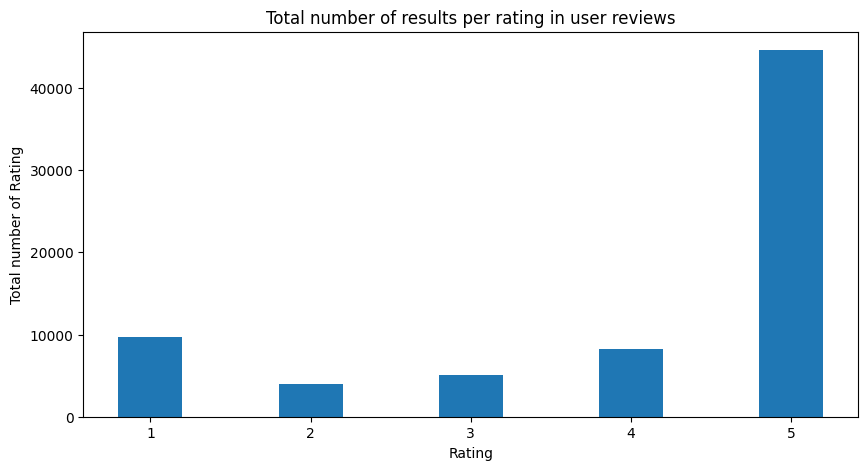

In [14]:
plt.rcParams["figure.figsize"] = (10, 5)  #=> Change diagram size
plt.rcParams["font.size"] = 10 #=> Change the font size

user_rating_count_df = review_df["rating"].value_counts().reset_index()
diagram_title = "Total number of results per rating in user reviews"
plt.bar(user_rating_count_df["rating"], user_rating_count_df["count"], width=0.4)
plt.title(diagram_title)
plt.xlabel("Rating")
plt.ylabel("Total number of Rating")
plt.show()

In [15]:
print(user_rating_count_df)

   rating  count
0       5  44620
1       1   9685
2       4   8206
3       3   5033
4       2   3953


### -- Show user review sentiment

In [16]:
def user_review_sentiment(rating):
    if(rating < 3):
        return "Negative"
    elif(rating == 3):
        return "Neutral"
    elif(rating > 3):
        return "Postive"

review_df["user_sentiment"] = review_df["rating"].apply(lambda x : user_review_sentiment(x))

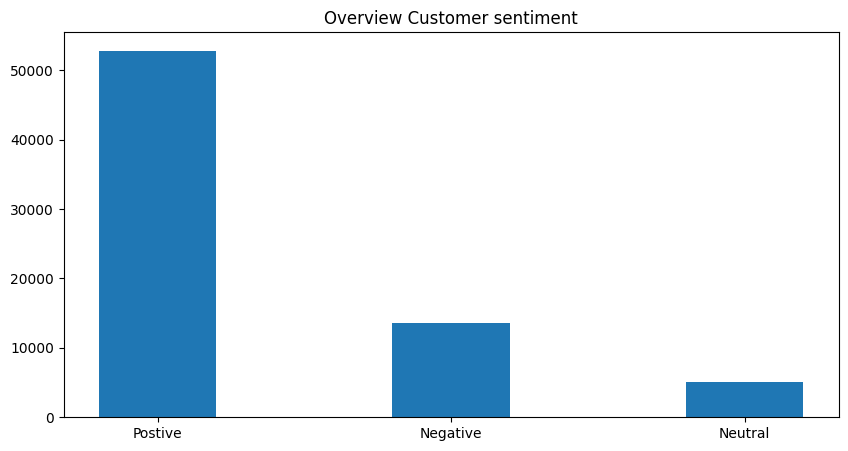

In [17]:
plt.rcParams["figure.figsize"] = (10, 5)  #=> Change diagram size
plt.rcParams["font.size"] = 10 #=> Change the font size

user_sentiment_count_df = review_df["user_sentiment"].value_counts().reset_index()
diagram_title = "Overview Customer sentiment"
plt.bar(user_sentiment_count_df["user_sentiment"], user_sentiment_count_df["count"], width=0.4)
plt.title(diagram_title)
plt.show()

### -- Show Top 10 most reviewed item

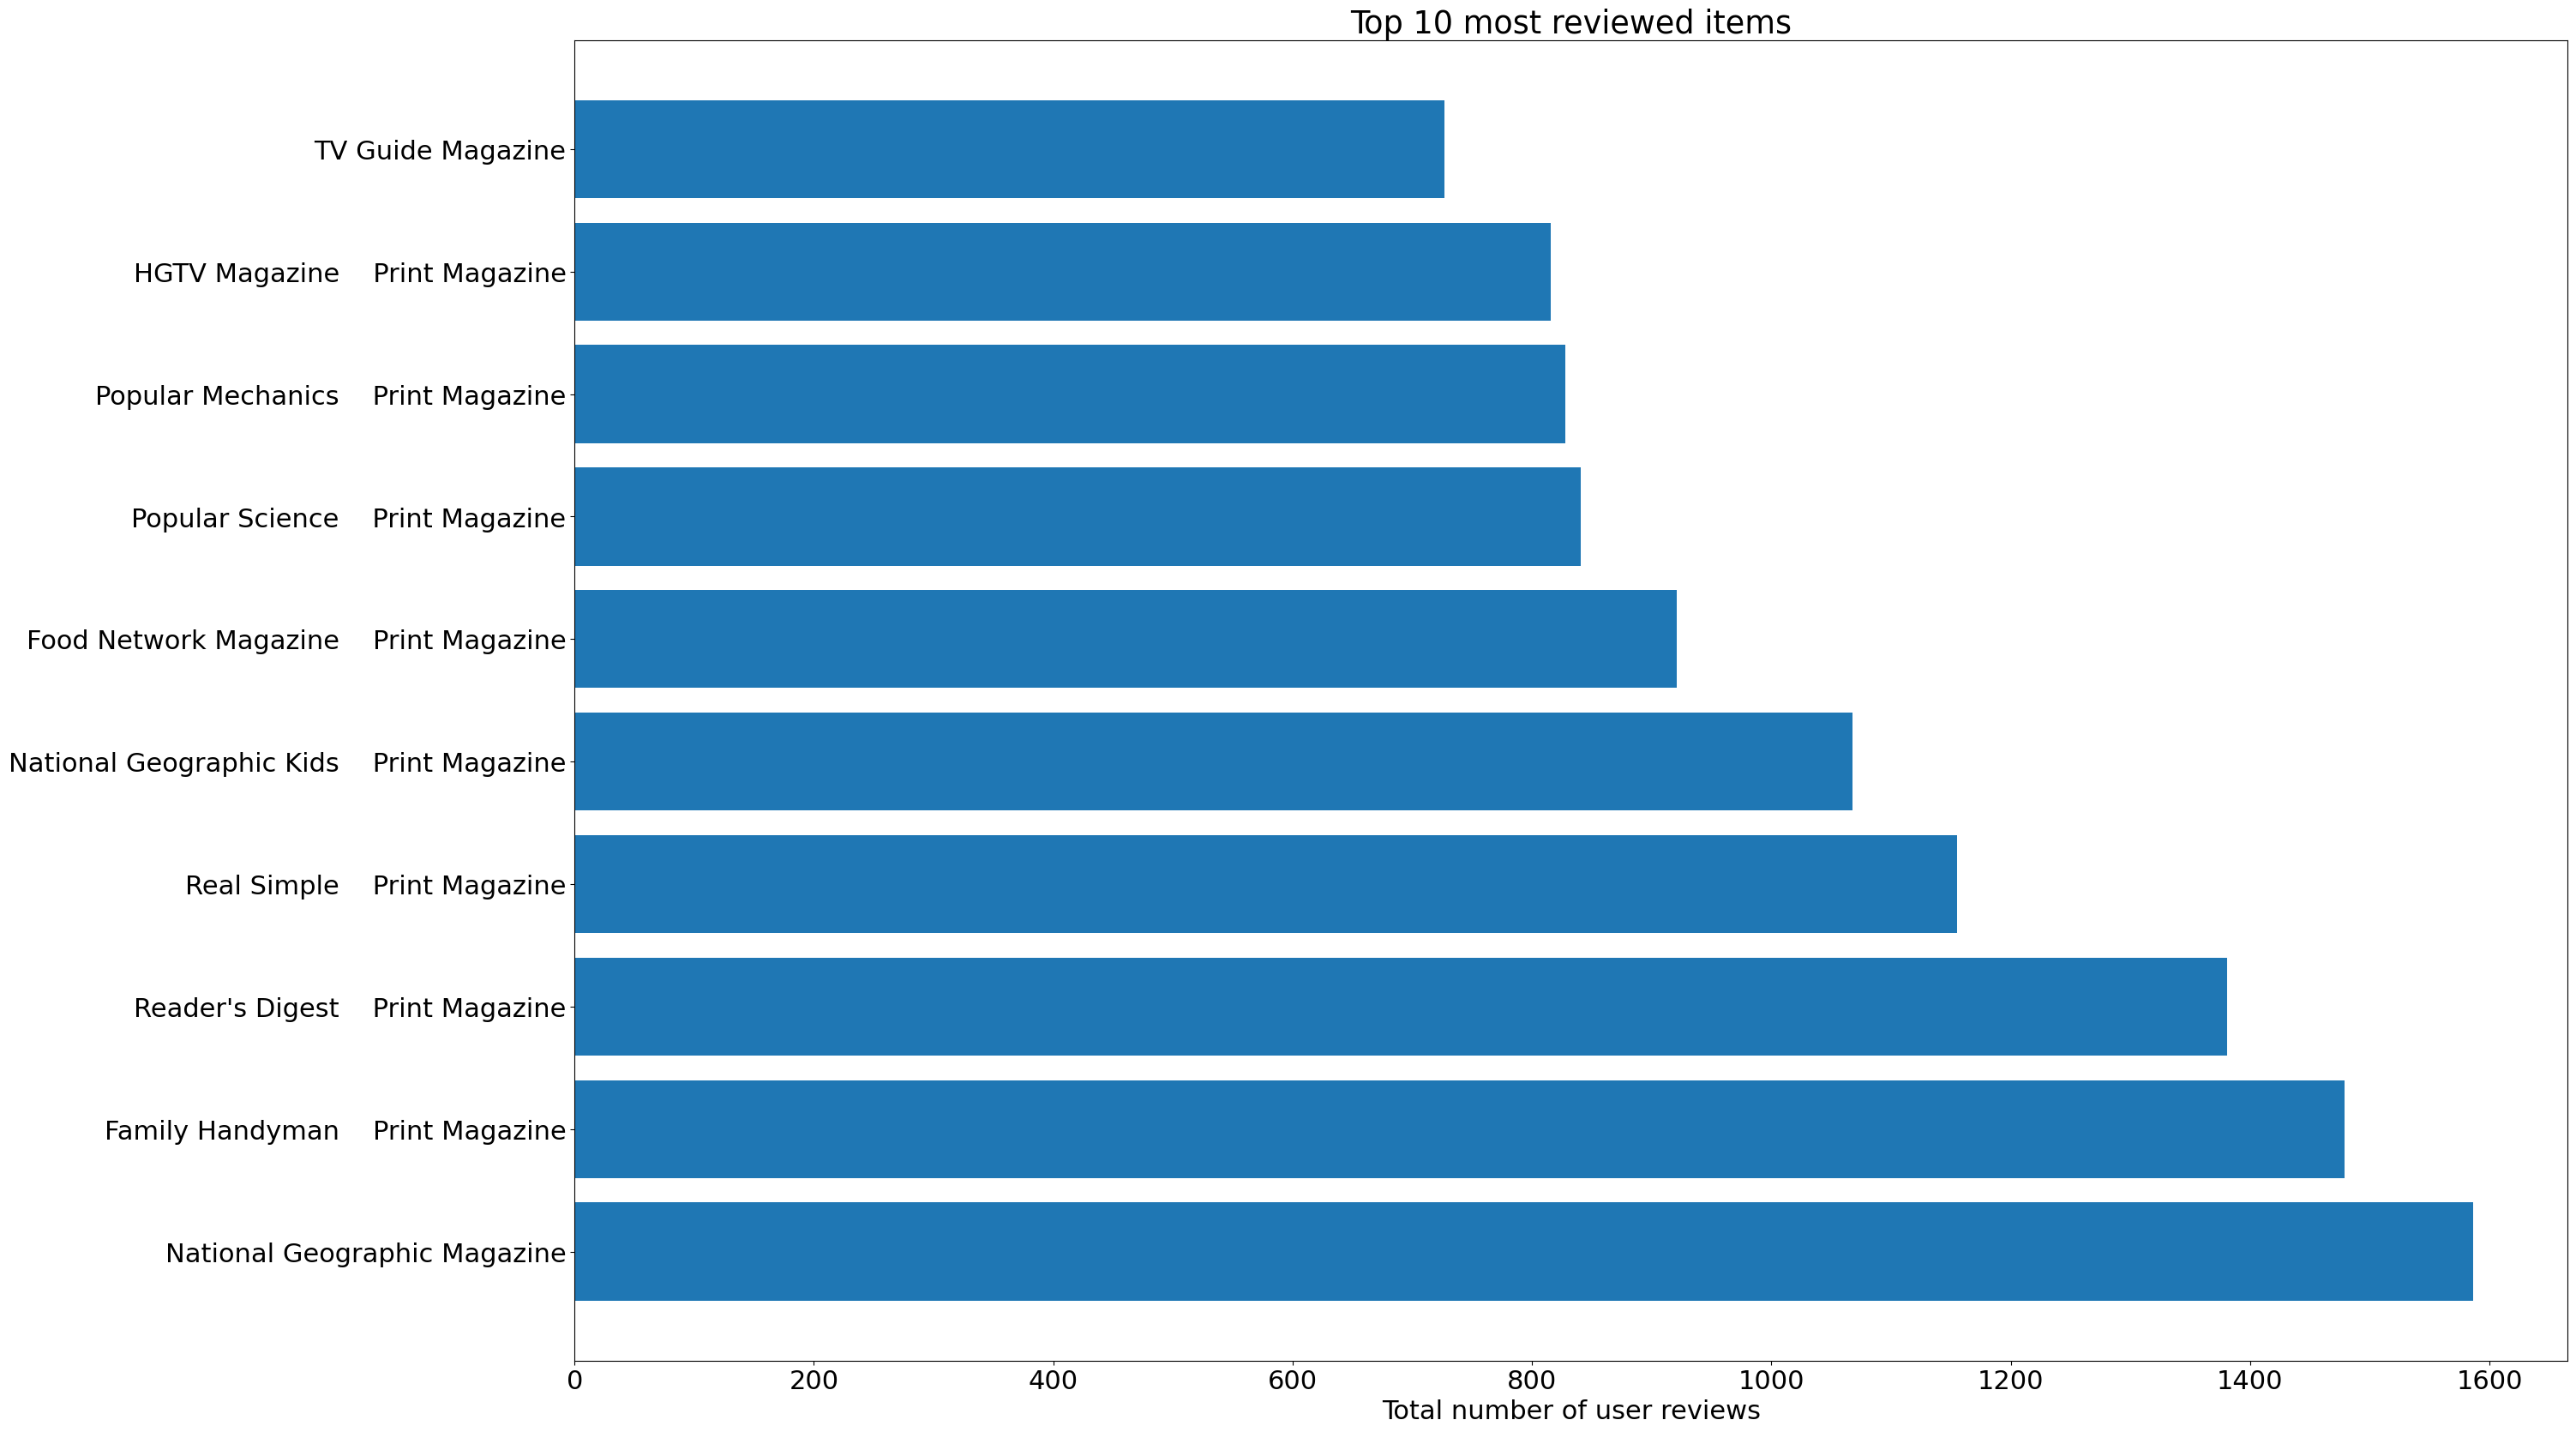

In [18]:
top10_most_item_df = review_df.groupby(by=["asin"]).agg({"user_id" : "count"}).reset_index()
top10_most_item_df.columns = ["item_id", "total_review"]
top10_most_item_df = top10_most_item_df.sort_values(by="total_review", ascending=False)
top10_most_item_df = top10_most_item_df.head(10)
top10_most_item_df = pd.merge(left=top10_most_item_df, right=item_df, left_on='item_id', right_on='parent_asin', how="left")

plt.rcParams["figure.figsize"] = (30, 20)  #=> Change diagram size
plt.rcParams["font.size"] = 22 #=> Change the font size
diagram_title = "Total number of results for each rating"
plt.barh(top10_most_item_df["title"], top10_most_item_df["total_review"])
plt.title("Top 10 most reviewed items")
plt.xlabel("Total number of user reviews")
plt.show()

### -- Show Top 10 highly rated and reviewed items

In [19]:
top10_high_rate_item_df = review_df.groupby(by=["asin"]).agg({"rating" : "mean", "user_id" : "count"}).reset_index()
top10_high_rate_item_df.columns = ["item_id", "rating", "total_review"]
top10_high_rate_item_df = top10_high_rate_item_df.sort_values(by=["rating", "total_review"], ascending=False)
top10_high_rate_item_df = top10_high_rate_item_df.head(10)
top10_high_rate_item_df = pd.merge(left=top10_high_rate_item_df, right=item_df, left_on='item_id', right_on='parent_asin', how="left")
top10_high_rate_item_df[["item_id", "title", "rating",  "total_review"]]

,item_id,title,rating,total_review
0,B00006KOUM,Mystery Scene Print Magazine,5.0,20
1,B00005Q7E3,Gray's Sporting Journal,5.0,12
2,B002PXW1BQ,Scotland Magazine,5.0,12
3,B0047VIAKK,Pastel Journal,5.0,12
4,B00006LD0G,Montana Outdoors,5.0,11
5,B002PXVZEA,Gray's Sporting Journal,5.0,10
6,B002PXW1UW,France,5.0,10
7,B00B8C8SVW,Current World Archaeology,5.0,10
8,B019R0URLA,Simple Grace Print Magazine,5.0,9
9,B00006KO0H,Mineralogical Record,5.0,8


### -- Show Top 10 users with high frequency ratings

In [20]:
top10_high_freq_user_df = review_df.groupby(by=["user_id"]).agg({"rating" : "count"}).reset_index()
top10_high_freq_user_df.columns = ["user_id", "total_rating_times"]
top10_high_freq_user_df = top10_high_freq_user_df.sort_values(by=["total_rating_times"], ascending=False)
top10_high_freq_user_df.head(10)

,user_id,total_rating_times
20135,AFERCDY2EFJKT7QUQ75GISNHTFOQ,61
5079,AEESP3UFZFWPXGH7YROPR55LVWHA,35
34014,AGCK7OO3T5VA4XRDC2IR4LETU57A,23
22336,AFJINHDZJTPW5JEPESQSRKPTJQ5Q,20
30792,AG3PVUKTDCJXOOPUKVOEGDDEHTPQ,20
43868,AGXFIFO4VWNHPAX3VJPRQ2QJSCSQ,19
54454,AHO4DJZABJPL3HV3N6LQ74I5RU6Q,19
43387,AGWDYYVVWM3DC3CASUZKXK67G6IA,18
59034,AHXRF6XBRDFS2VVLJT45AOSJWGQA,18
29068,AFXXHEHPTALPTJASXHRGON4PSZQA,17


### -- Show Total number of reviews by year

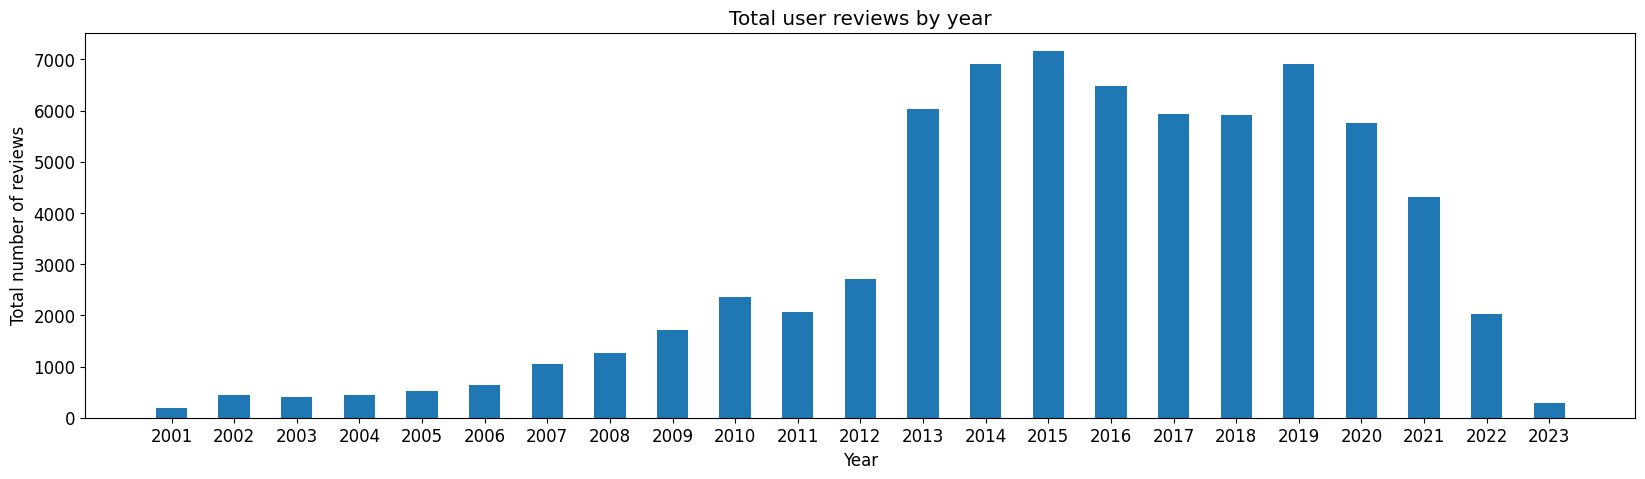

In [21]:
review_df["date_year"] = review_df["timestamp"].dt.year
review_df["date_month"] = review_df["timestamp"].dt.month
review_df["date_day"] = review_df["timestamp"].dt.day
review_df["date_week"] = review_df["timestamp"].dt.dayofweek

yearly_post_agg_df = review_df.groupby(by=["date_year"]).agg({"user_id" : "count"}).reset_index()
yearly_post_agg_df.columns = ["date_year", "total_review"]

#--- Plot Top 10 of PoS diagram ---
plt.rcParams["figure.figsize"] = (20, 5)  #=> Change diagram size
plt.rcParams["font.size"] = 12 #=> Change the font size

diagram_title = "Total user reviews by year"
plt.bar(yearly_post_agg_df["date_year"], yearly_post_agg_df["total_review"], width=0.5)
plt.title(diagram_title)
plt.xlabel("Year") #=> Set X label
plt.ylabel("Total number of reviews") #=> Set Y label

#--- Set label in x-coordinate ---
plt.xticks(yearly_post_agg_df["date_year"], yearly_post_agg_df["date_year"])
plt.show()

### -- Show user review word cloud diagram

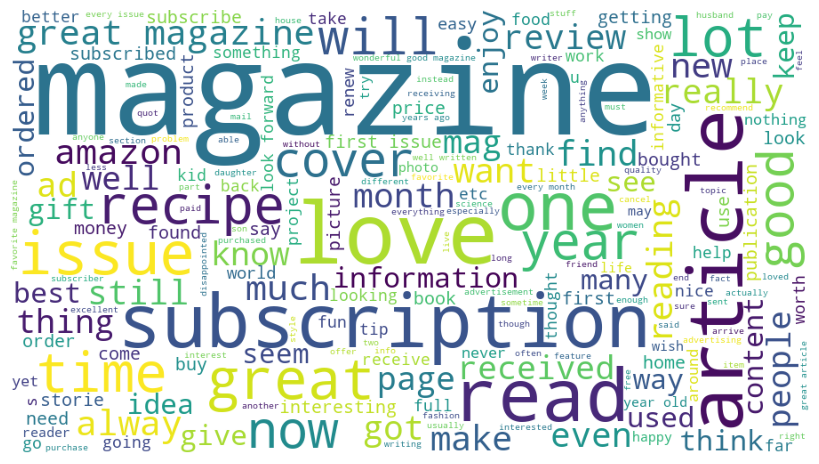

In [22]:
#--- remove HTML tag ---
def remove_html_tag(sentences):
    sentences = re.sub(r'<.*?>', "", sentences)
    return sentences    
    
all_review_text = " ".join(review_df["text"].tolist())
all_review_text = all_review_text.lower()
all_review_text = remove_html_tag(all_review_text)

final_word_tokenizer = RegexpTokenizer("[\w']+") #=> allow remove punctuations in sentences
all_review_text = final_word_tokenizer.tokenize(all_review_text)
all_review_text = " ".join(all_review_text)

stopwords = set(STOPWORDS) #=> get stopwords
wordcloud = WordCloud(width = 900, height = 500, background_color ='white', stopwords = stopwords, min_font_size = 10).generate(all_review_text)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

## - Training Model section

### -- Create Train and Test datasets

In [23]:
reader = Reader()
review_datesets = Dataset.load_from_df(review_df[['user_id', 'parent_asin', 'rating']], reader)

#--- Split train datasets and test datasets ---
train_datasets, test_datasets = train_test_split(review_datesets, test_size=split_ratio, random_state = random_seed)

print("Size of train datasets: ", train_datasets.n_ratings)
print("Size of test datasets: ", len(test_datasets))

Size of train datasets:  57197
Size of test datasets:  14300


### -- Create Plot diagram and Evaluation model function

In [24]:
#--- Set Boxplot attribute ---
def set_boxplot_attribute(plot_name, color_code, label_name):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)        
    # use plot function to draw a small line to name the legend.
    plt.plot([], c=color_code, label=label_name)
    plt.legend()
    
#--- Plot boxplot cross valid diagram ---
def plot_boxplot_cross_valid_diagram(dict_cross_valid_scores, list_model, list_metric_label_name, diagram_title, color=[]):
    if(len(list_model) == 1):
        plt.rcParams["figure.figsize"] = (5, 5)  #=> Change diagram size
        plt.rcParams["font.size"] = 12 #=> Change the font size
    else:
        plt.rcParams["figure.figsize"] = (30, 8)  #=> Change diagram size
    
        plt.rcParams["font.size"] = 22 #=> Change the font size
    list_color_name = color#['red', 'green'] #=> boxplot color
    
    #--- Group cross validation in dictionary ---
    dict_diagram = defaultdict(dict)
    dict_return_mean_values = defaultdict(dict)    
    list_model_name = [this_model[0] for this_model in list_model]
    for this_metric_label_name in list_metric_label_name:
        for this_model in list_model:
            this_model_name = this_model[0] #==> get this model name
            if((this_metric_label_name not in dict_diagram)): #--- check this feature extraction name exist ---
                dict_diagram[this_metric_label_name] = [dict_cross_valid_scores[this_model_name][this_metric_label_name]]
            else:
                dict_diagram[this_metric_label_name].append(dict_cross_valid_scores[this_model_name][this_metric_label_name])
            
            #--- Get this cross-validation mean values ---
            dict_return_mean_values[this_model_name][this_metric_label_name] = dict_cross_valid_scores[this_model_name][this_metric_label_name].mean()
    
    #--- Calculate group boxplot position ---
    color_index = 0
    position_index = 0.2
    if(len(list_metric_label_name) == 3):
        position_index = -0.35
    elif(len(list_metric_label_name) == 2):
        position_index = -0.2

    for this_key, this_feature_extraction_method_cv in dict_diagram.items():
        this_positions = np.array(np.arange(len(this_feature_extraction_method_cv)))*2.0+position_index
        this_plot = plt.boxplot(this_feature_extraction_method_cv, positions=this_positions, widths=0.4) #patch_artist=True,
        set_boxplot_attribute(this_plot, list_color_name[color_index], this_key) #--- set boxplot attribute ---
        
        if(len(list_metric_label_name) == 3):
            position_index = position_index + 0.4
        elif(len(list_metric_label_name) == 2):
            position_index = position_index + 0.7
        color_index = color_index + 1

    plt.xticks(np.arange(0, len(list_model_name) * 2, 2)+0.2, list_model_name)
    plt.title(diagram_title) #=> Set diagram title name
    plt.show()
    
    return pd.DataFrame(dict_return_mean_values)

#--- Plot compare experiment line chart ---
def plot_compare_experiment_line_chart(list_model, list_k_recommendation, model_results, x_label, y_label, diagram_title):
    #dict_exp_resuls = defaultdict(dict)
    for this_model in list_model: #--- Loop our model ---
        this_model_name = this_model[0] #--- Get model name ---
        list_model_result = []
        
        for this_k in list_k_recommendation:
            list_model_result.append(model_results[this_model_name][this_k])
        plt.plot(list_model_result, label=this_model_name, marker='o') #--- plot line chart 
        
    plt.rcParams["figure.figsize"] = (10, 5)  #=> Change diagram size
    plt.rcParams["font.size"] = 10 #=> Change the font size    
    list_labels = [k for k in list_k_recommendation]
    plt.xticks(ticks=range(len(list_labels)), labels=list_labels) #=> Set x label name
    plt.legend(loc="lower right") #=> Set legend position
    plt.title(diagram_title) #=> Set diagram title name
    plt.xlabel(x_label) #=> Set X label
    plt.ylabel(y_label) #=> Set Y label
    plt.show()


#--- Get precision and recall rate at k of recommendation item ---
def get_precision_recall_at_k(predictions, k=10, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True) # Sort user ratings by estimated value
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings) # Number of relevant items (true case)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k]) # Number of recommended items in top k

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(
            ((true_r >= threshold) and (est >= threshold))
            for (est, true_r) in user_ratings[:k]
        )
        
        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        
        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
    
    #--- Calculate precision result ---
    model_precision = sum(prec for prec in precisions.values()) / len(precisions)
    
    #--- Calculate recall result ---
    model_recall = sum(rec for rec in recalls.values()) / len(recalls)
    
    return model_precision, model_recall

### -- Training All Models

In [25]:
#--- store the trained model ---
methodology_result_dict_model = defaultdict(dict)

for this_model_data in list_model: #==> Loop different model 
    this_model_name = this_model_data[0] #==> get this model name
    this_model = this_model_data[1] #==> get this model
    
    #--- Store trained model in dictionary ---
    methodology_result_dict_model[this_model_name] = this_model.fit(train_datasets)

Computing the msd similarity matrix...
Done computing similarity matrix.


## - Check the model performance section

### -- Cross-Validation All Models

In [26]:
methodology_result_cross_valid_score = defaultdict(dict)
methodology_result_train_prediction = defaultdict(dict)

#--- Create datasets for evaluate models ---
cv_train_datesets = Dataset.load_from_df(pd.DataFrame(train_datasets.build_testset(), columns=['user_id', 'parent_asin', 'rating']), reader)

for this_model_data in list_model: #==> Loop different model 
    this_model_name = this_model_data[0] #==> get this model name
    this_model = methodology_result_dict_model[this_model_name] #==> get trained model
    
    #--- Store cv MAE in dictionary ---
    methodology_result_cross_valid_score[this_model_name] = cross_validate(this_model, cv_train_datesets, measures=measure_model_methods, cv=cv_fold, verbose=True)
    
    #--- Store prediction results in dictionary ---
    this_train_prediction = this_model.test(train_datasets.build_testset())
    methodology_result_train_prediction[this_model_name] = this_train_prediction    

Evaluating MAE of algorithm NormalPredictor on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
MAE (testset)     1.3965  1.4143  1.3952  1.4302  1.4043  1.4252  1.4007  1.4026  1.4083  1.4280  1.4105  0.0125  
Fit time          0.05    0.06    0.07    0.07    0.07    0.07    0.07    0.07    0.07    0.07    0.07    0.01    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.02    0.03    0.04    0.02    0.02    0.01    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Do

### -- Show Models performance results

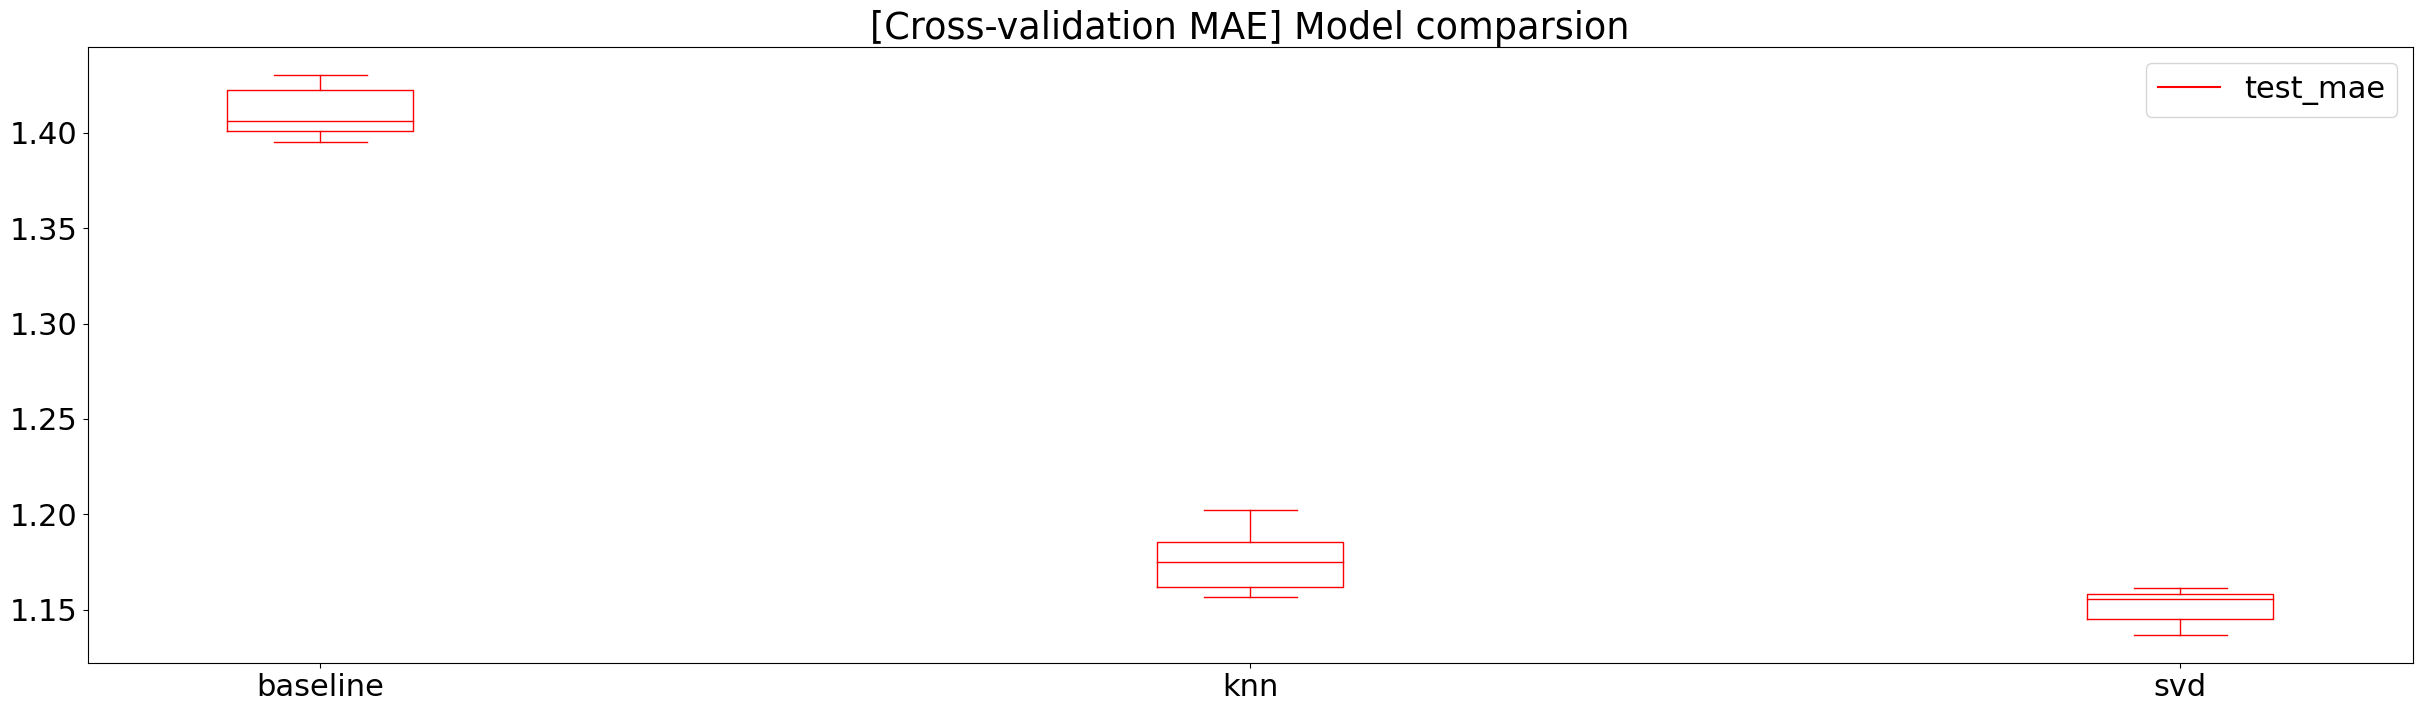

In [27]:
df_model_mae = plot_boxplot_cross_valid_diagram(methodology_result_cross_valid_score, list_model, ["test_mae"], "[Cross-validation MAE] Model comparsion", ["red"])

In [28]:
display(df_model_mae.applymap('{:,.3f}'.format))

,baseline,knn,svd
test_mae,1.411,1.175,1.151


### -- Show Models Precision and Recall results

In [29]:
all_model_precisions = defaultdict(dict) 
all_model_recalls = defaultdict(dict)

for this_model_data in list_model: #==> Loop different model 
    this_model_name = this_model_data[0] #==> get this model name
    this_model_train_prediction = methodology_result_train_prediction[this_model_name] #==> get prediction result
    
    for this_k in list_k_recommendation: #==> Loop number of recommendation
        
        #--- Get precision and recall ---
        this_model_precision, this_model_recall = get_precision_recall_at_k(this_model_train_prediction, k=this_k, threshold=evaluate_rs_threshold)
        
        #--- Store model precisions in dictionary ---
        all_model_precisions[this_model_name][this_k] = this_model_precision
        
        #--- Store model recall in dictionary ---
        all_model_recalls[this_model_name][this_k] = this_model_recall

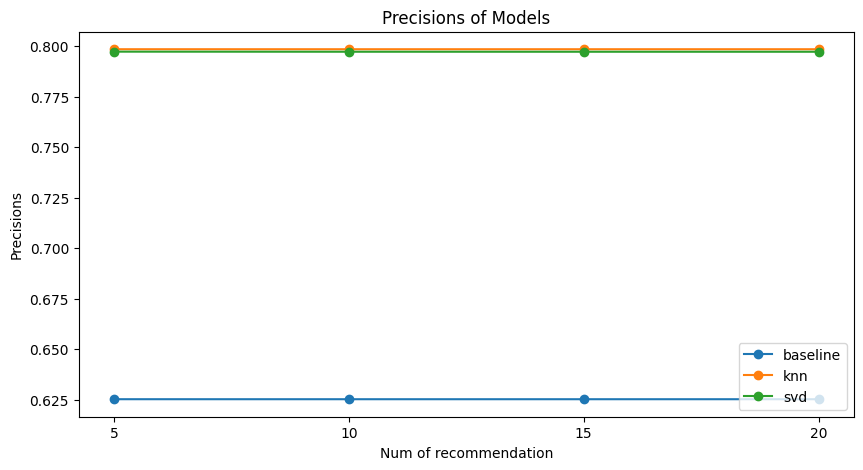

In [34]:
plot_compare_experiment_line_chart(list_model, list_k_recommendation, all_model_precisions, "Num of recommendation", "Precisions", "Precisions of Models")

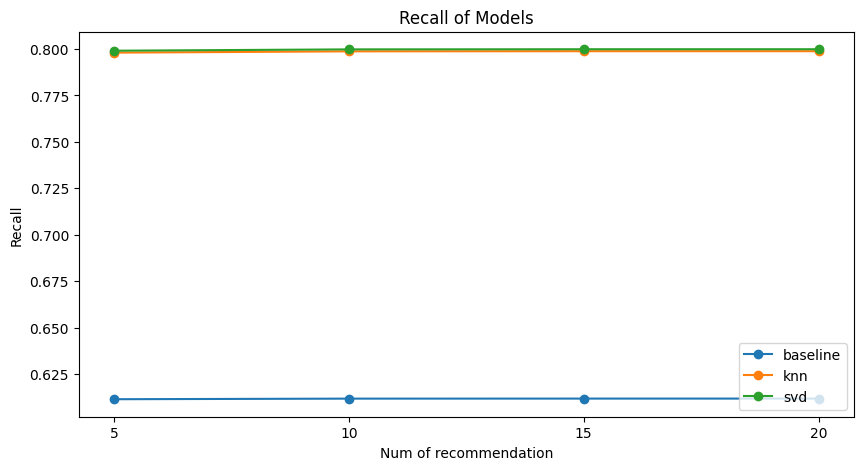

In [35]:
plot_compare_experiment_line_chart(list_model, list_k_recommendation, all_model_recalls, "Num of recommendation", "Recall", "Recall of Models")

In [36]:
pd.DataFrame(all_model_precisions)

,baseline,knn,svd
5,0.625288,0.798402,0.797194
10,0.625282,0.798397,0.797155
15,0.625283,0.798397,0.797148
20,0.625283,0.798397,0.797147


In [37]:
pd.DataFrame(all_model_recalls)

,baseline,knn,svd
5,0.611581,0.798006,0.799046
10,0.611901,0.798704,0.799765
15,0.611923,0.798776,0.799840
20,0.611929,0.798783,0.799848


## - Grid Search Best Model

In [38]:
param_grid = {"n_epochs": [20, 30, 50], "n_factors":[50, 100, 150], "lr_all": [0.002, 0.005, 0.001], "reg_all": [0.02, 0.1, 0.3]}
gridsearch_model = GridSearchCV(SVD, param_grid, measures=measure_model_methods, cv=cv_fold)
gridsearch_model.fit(cv_train_datesets)

## - Show Best Model Hyper-parameters

In [39]:
print("Best RMSE score : " + str(gridsearch_model.best_score["mae"]))
print("Best Hyper-parameters : " + str(gridsearch_model.best_params["mae"]))

Best RMSE score : 1.135299950648546
Best Hyper-parameters : {'n_epochs': 50, 'n_factors': 50, 'lr_all': 0.005, 'reg_all': 0.02}


## - Compare the best model in the test dataset to the baseline

In [40]:
best_epochs = 50
best_n_factors = 50
best_lr_all = 0.005
best_reg_all = 0.02

best_model = SVD(n_epochs=best_epochs, n_factors=best_n_factors, lr_all=best_lr_all, reg_all=best_reg_all)
best_model.fit(train_datasets)

In [41]:
best_model_train_prediction = best_model.test(test_datasets)
best_model_precision, best_model_recall = get_precision_recall_at_k(best_model_train_prediction, k=10, threshold=evaluate_rs_threshold)
print("Best Model Precision K@10 : " + str(best_model_precision))
print("Best Model Recall K@10 : " + str(best_model_recall))

Best Model Precision K@10 : 0.7989703419056066
Best Model Recall K@10 : 0.8006145925706967


In [42]:
base_model_test_prediction = methodology_result_dict_model["baseline"].test(test_datasets)
baseline_model_precision, baseline_model_recall = get_precision_recall_at_k(base_model_test_prediction, k=10, threshold=evaluate_rs_threshold)
print("Baseline Model Precision K@10 : " + str(baseline_model_precision))
print("Baseline Model Recall K@10 : " + str(baseline_model_recall))

Baseline Model Precision K@10 : 0.617362548034289
Baseline Model Recall K@10 : 0.6116526258744703


## - Retrain the best model on the entire dataset

In [43]:
whole_datasets = review_datesets.build_full_trainset()

deploy_best_model = SVD(n_epochs=best_epochs, n_factors=best_n_factors, lr_all=best_lr_all, reg_all=best_reg_all)
deploy_best_model.fit(whole_datasets)

## - Export the Best Model

In [44]:
whole_predictions_result = deploy_best_model.test(whole_datasets.build_testset())
dump.dump(export_model_folder+export_model_file, whole_predictions_result, deploy_best_model)

---
<center><strong>The End of Assignment 2</strong></center>

---